In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [30]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

# 파이토치 사용할때 커널 충돌 문제 해결

In [31]:
mnist_train = datasets.MNIST('MINIST_data', 
                             train = True, 
                             download=True, 
                             transform=transforms.Compose([transforms.ToTensor()])) # train data를 가져옴

mnist_test = datasets.MNIST('MINIST_data', 
                             train = False, # False로 설정하면 test data를 가져옴
                             download=True, 
                             transform=transforms.Compose([transforms.ToTensor()])) # test data를 가져옴

In [32]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MINIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: MINIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [33]:
print(mnist_train.data.shape) # 60000개의 이미지 데이터, 28*28 크기의 이미지
print(mnist_train.targets.shape) # 60000개의 이미지 데이터에 대한 정답 레이블

print(mnist_test.data.shape) 
print(mnist_test.targets.shape) 

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [34]:
# 데이터 이미지 확인

def plot(x): 
    img=(np.array(x.detach(), dtype='float')).reshape(28,28)
    plt.imshow(img, cmap='grey')
    plt.show()

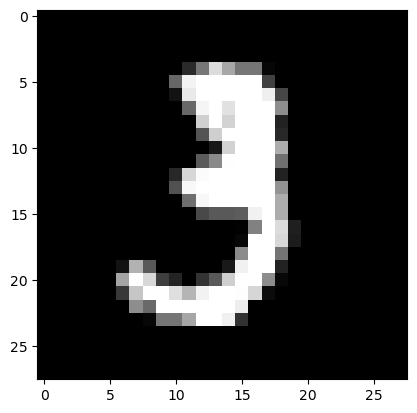

In [35]:
plot(mnist_train.data[10]) #11번째 이미지 출력

In [36]:
print(mnist_train.targets[10]) # tensor로 출력

tensor(3)


In [37]:
print(mnist_train.targets[10])
print(mnist_train.data.shape)
print(mnist_train.targets.shape)

tensor(3)
torch.Size([60000, 28, 28])
torch.Size([60000])


In [38]:
x = mnist_train.data[10]
x

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [39]:
# 0 ~ 1 사이의 값으로 정규화

x = mnist_train.data.float() / 255 # 데이터 스케일 조정 => 0~1사이의 값으로 정규화
#x[0] 
y = mnist_train.targets
#y[:10] 

print(x.size())
print(y.size())
x=x.view(x.size(0),-1) # 2차원 데이터를 1차원으로 변환

input_size = x.size(-1) # -1은 마지막 차원을 의미. 입력데이터 크기
print(input_size) 
output_size=int(max(y))+1 # 제일 큰 값에 1을 더해줌 => 10. 출력데이터 크기
print(output_size)

torch.Size([60000, 28, 28])
torch.Size([60000])
784
10


In [40]:
#훈련 데이터(train)와 검증 데이터(valid) 분리

ratio = [0.8, 0.2] # 훈련 데이터와 검증 데이터 비율
train_cnt=int(x.size(0)*ratio[0]) # 훈련 데이터 개수
valid_cnt=int(x.size(0)*ratio[1]) # 검증 데이터 개수
test_cnt=len(mnist_test.data) # 테스트 데이터 개수

print(train_cnt, valid_cnt, test_cnt)
cnts=[train_cnt, valid_cnt]

indices=torch.randperm(x.size(0)) # 데이터 인덱스 섞기 위해 랜덤으로 섞음 

#print(indices[0:20])

x=torch.index_select(x, dim=0, index=indices) # 데이터 섞음
y=torch.index_select(y, dim=0, index=indices) # y도 인덱스 맞춰서 섞음
#plot(x[0]) # 데이터 확인 -> 섞인 데이터 확인 가능
#y[0] # x[0]에 대한 y값 맞춰짐 

x1=list(x.split(cnts, dim=0)) # 데이터 분할
y1=list(y.split(cnts, dim=0)) # y값도 데이터 분할
print(x1[0].shape, x1[1].shape) # 훈련, 검증, 테스트 데이터 개수 확인
print(y1[0].shape, y1[1].shape) # 훈련, 검증, 테스트 데이터 개수 확인

x1+=[(mnist_test.data.float()/255).view(test_cnt, -1)] # 2차원으로 변환
y1+=[mnist_test.targets]

for ii in x1:
    print(ii.shape)

for yi in y1:
    print(yi.shape)



48000 12000 10000
torch.Size([48000, 784]) torch.Size([12000, 784])
torch.Size([48000]) torch.Size([12000])
torch.Size([48000, 784])
torch.Size([12000, 784])
torch.Size([10000, 784])
torch.Size([48000])
torch.Size([12000])
torch.Size([10000])


In [41]:
model=nn.Sequential(
    nn.Linear(input_size, 500), # 입력층
    nn.LeakyReLU(),
    nn.Linear(500, 400), # 은닉층 ( 앞의 값의 뒤 값과 은닉층 값의 앞 값이 같아야함)
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size), # 출력층
    nn.Softmax(dim=-1) # 출력층의 활성화 함수
)
model


Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): Softmax(dim=-1)
)

In [42]:
# 모델 훈련

crit = nn.CrossEntropyLoss() # 손실함수
optimizer = optim.Adam(model.parameters()) # 옵티마이저 


In [43]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [44]:
model = model.to(device) # 모델을 gpu로 보냄 -> cuda 사용할때 설정 필요
x2=[x_i.to(device) for x_i in x1]
y2=[y_i.to(device) for y_i in y1]


In [45]:
# 훈련

epochs = 1000
batch_size = 256 # 배치 사이즈(한번에 학습시킬 데이터 양)
print_interval = 10 # 출력 간격

In [46]:
# 새로운 데이터 넣었을때 가장 낮은 loss값을 가진 모델을 저장하기 위한 변수


from copy import deepcopy # 모델 복사

lowest_loss = np.inf # 가장 낮은 loss값을 저장하기 위한 변수 
bast_model=None

early_stop = 50  # 50번 이상 loss값이 증가하면 학습 종료 
lowest_epoch = np.inf # 가장 낮은 loss값을 가진 epoch 저장 

In [47]:
y2[:10] # y값 확인 -> 1차원. 2차원으로 만들어야함 

[tensor([6, 7, 7,  ..., 2, 7, 4]),
 tensor([7, 2, 9,  ..., 1, 2, 9]),
 tensor([7, 2, 1,  ..., 4, 5, 6])]

In [60]:
# 훈련 시작

train_history, valid_history = [], []

for i in range(epochs) :
    indices=torch.randperm(x2[0].size(0)).to(device) # 데이터 섞기
    x_=torch.index_select(x2[0], dim=0, index=indices) # x 훈련 데이터 섞음
    y_=torch.index_select(y2[0], dim=0, index=indices) # y값도 섞음

    x_=x_.split(batch_size, dim=0) # 배치 사이즈로 데이터 나눔
    y_=y_.split(batch_size, dim=0) # 배치 사이즈로 y값 나눔
    #print(x_[0].size())
    #print(y_[0].size())

    train_loss, valid_loss = 0, 0 # 훈련 데이터 loss값, 검증 데이터 loss값 초기화 => 한 batch마다 loss값 계산하기 위해
    y_hat = []

    for x_i, y_i in zip(x_, y_) : # zip 함수를 사용하여 x와 y값을 묶어서 tensor로 변환
        y_hat_i = model(x_i) # 모델에 x값 넣어서 y값 예측
        loss = crit(y_hat_i, y_i.squeeze()) # y_i를 2차원으로 만들어서 loss값 계산

        optimizer.zero_grad() # 기울기 초기화
        loss.backward()
        optimizer.step()
        train_loss+=float(loss) # loss값 계산해서 누적 

    train_loss= train_loss/len(x_) # loss값 계산. len(x_)는 배치 사이즈로 나눈 값(train_loss/256)

    with torch.no_grad(): # 검증 데이터는 기울기 계산 필요없음
        x_=x2[1].split(batch_size, dim=0) # 검증 데이터 배치 사이즈로 나눔 -> 똑같은 사이즈로 만들기위해 
        y_=y2[1].split(batch_size, dim=0) 

        for x_i, y_i in zip(x_, y_) : # zip 함수를 사용하여 x와 y값을 묶어서 tensor로 변환
            y_hat_i=model(x_i) # 모델에 x값 넣어서 y값 예측
            loss=crit(y_hat_i, y_i) # loss값 계산
            valid_loss+=float(loss) 

            y_hat+=[y_hat_i] 
    valid_loss=valid_loss/len(x_) # loss값 계산

    train_history+= [train_loss] # 훈련 데이터 loss값 저장
    valid_history+= [valid_loss] # 검증 데이터 loss값 저장

    #출력
    if (i+1) % print_interval == 0:
        print(i, train_loss, valid_loss, lowest_loss) # epoch, 훈련 데이터 loss값, 검증 데이터 loss값 출력

    if valid_loss <= lowest_loss: # 검증 데이터 loss값이 가장 낮을때 모델 저장
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict()) # 작은 값 구해질때마다 모델 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1: 
            print('%d{} 이후 %d epoch 증가하는 동안 loss가 감소하지 않아 학습을 종료합니다.' %(lowest_epoch, early_stop))
            break

print('epoch %d일때 손실함수 %.4f로 가장 낮음' %(lowest_epoch, lowest_loss))



9 1.5966222153065053 1.5648603439331055 0.3149160998208182
19 1.5499699940072729 1.5376467552590878 0.3149160998208182
29 1.604508178031191 1.607516864512829 0.3149160998208182
39 1.5510332337085238 1.5669940938340856 0.3149160998208182
49 1.5906569742141885 1.579848882999826 0.3149160998208182
59 1.698840320110321 1.6836152964449944 0.3149160998208182
16{} 이후 50 epoch 증가하는 동안 loss가 감소하지 않아 학습을 종료합니다.
epoch 16일때 손실함수 0.3149로 가장 낮음


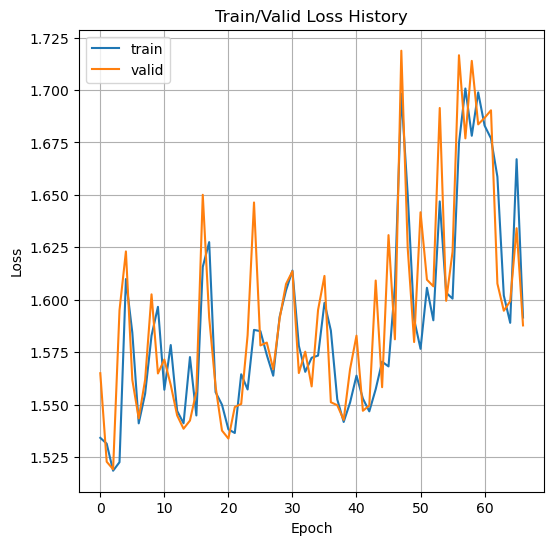

In [61]:
import matplotlib.pyplot as plt


# 데이터 길이 확인
assert len(train_history) == len(valid_history), "train_history와 valid_history의 길이가 다릅니다."

plot_from=0
plt.figure(figsize=(6,6))
plt.grid(True)
plt.title('Train/Valid Loss History')
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], #x축, y축
         range(plot_from, len(valid_history)), valid_history[plot_from:]) 
# 데이터 차이가 많이 남 -> 학습 잘 안됨. 과적합 발생 가능성 높음
plt.legend(['train', 'valid']) # 범례
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=x2[-1].split(batch_size, dim=0) # 테스트 데이터 배치 사이즈로 나눔
    y_=y2[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i, y_i.squeeze())

        test_loss+=loss
        y_hat+=[y_hat_i] 

test_loss=test_loss/len(x_) # loss값 계산
y_hat=torch.cat(y_hat, dim=0) # y_hat을 하나로 합침
print('test loss:', test_loss) 

test loss: tensor(1.5280)


In [56]:
correct_cnt=(y2[-1].squeeze()==torch.argmax(y_hat, dim=-1)).sum() # 정답과 예측값이 같은 개수
print(correct_cnt/10000)


tensor(0.9330)


In [59]:
import pandas as pd
from sklearn.metrics import confusion_matrix

df=pd.DataFrame(confusion_matrix(y2[-1], torch.argmax(y_hat, dim=-1)),
                index=['true_%d' %i for i in range(10)],
                columns=['pred_%d' %i for i in range(10)])
df

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,968,0,4,1,0,0,4,0,3,0
true_1,0,1117,7,2,0,0,5,0,4,0
true_2,8,2,1005,2,1,0,9,0,5,0
true_3,0,0,48,927,0,12,0,1,22,0
true_4,4,2,15,0,901,0,16,2,5,37
true_5,12,1,2,21,1,799,32,0,22,2
true_6,9,3,1,0,3,2,939,0,1,0
true_7,6,9,121,17,3,0,1,854,6,11
true_8,3,2,20,7,4,0,14,0,924,0
true_9,13,7,4,24,22,4,3,2,34,896
